### No Transformation was made on the target data

Evaluating with MinMaxScaler
Best parameters found with MinMaxScaler:  {'model__bootstrap': True, 'model__max_depth': 6, 'model__min_samples_leaf': 9, 'model__min_samples_split': 2, 'model__n_estimators': 739}
Best cross-validation score with MinMaxScaler:  0.3380421213070865


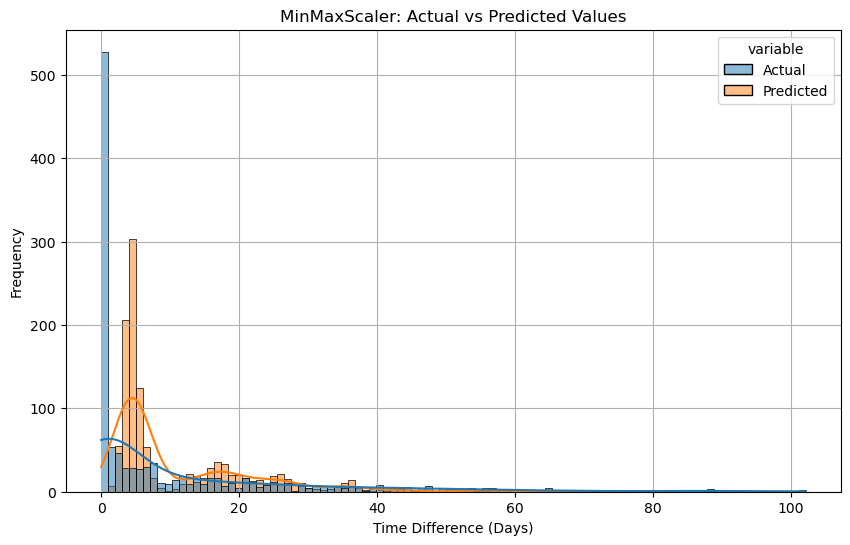

Evaluating with StandardScaler
Best parameters found with StandardScaler:  {'model__bootstrap': True, 'model__max_depth': 6, 'model__min_samples_leaf': 9, 'model__min_samples_split': 2, 'model__n_estimators': 739}
Best cross-validation score with StandardScaler:  0.338050128693602


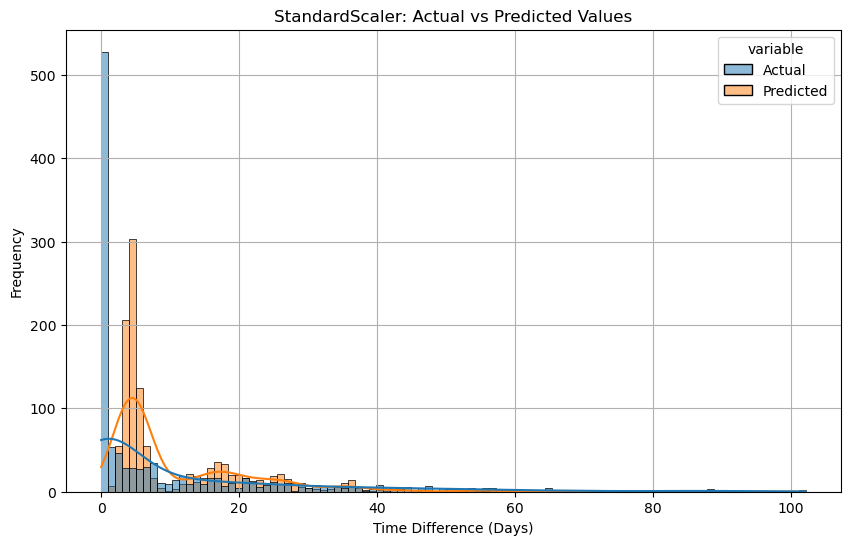

Evaluating with RobustScaler
Best parameters found with RobustScaler:  {'model__bootstrap': True, 'model__max_depth': 6, 'model__min_samples_leaf': 9, 'model__min_samples_split': 2, 'model__n_estimators': 739}
Best cross-validation score with RobustScaler:  0.3380562748580763


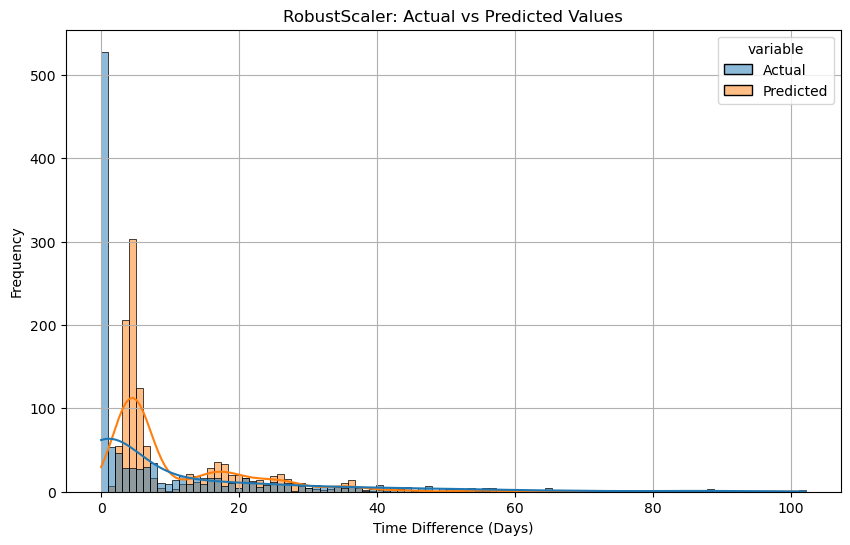

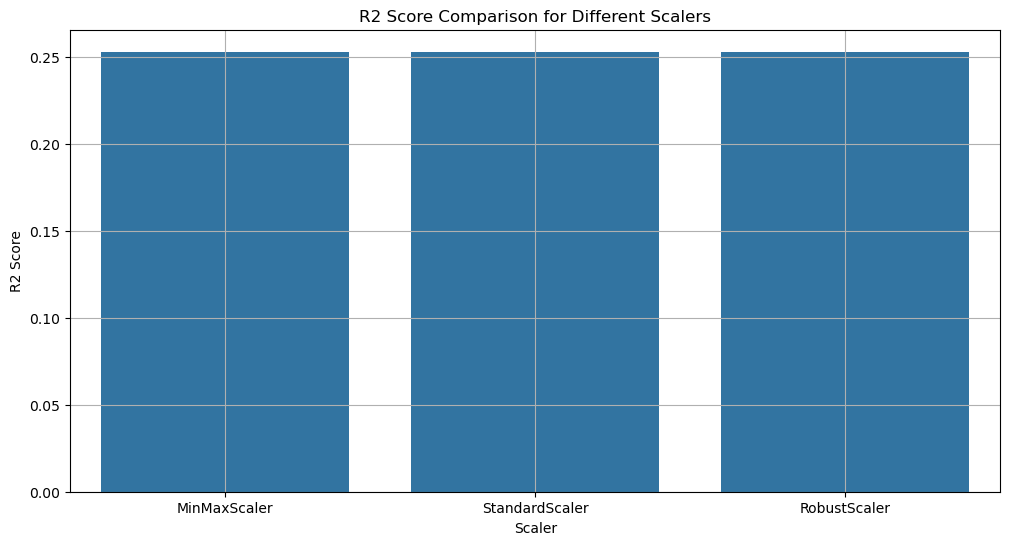

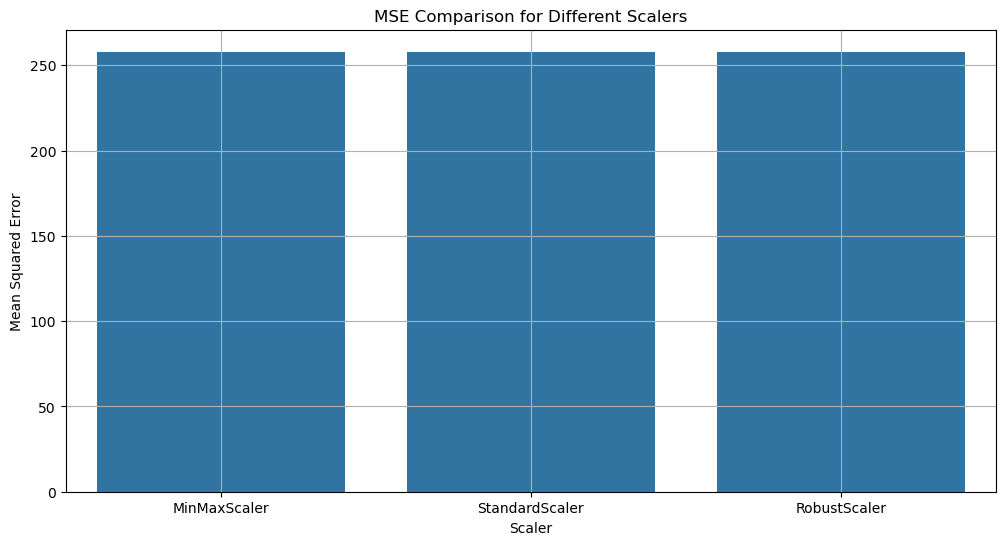

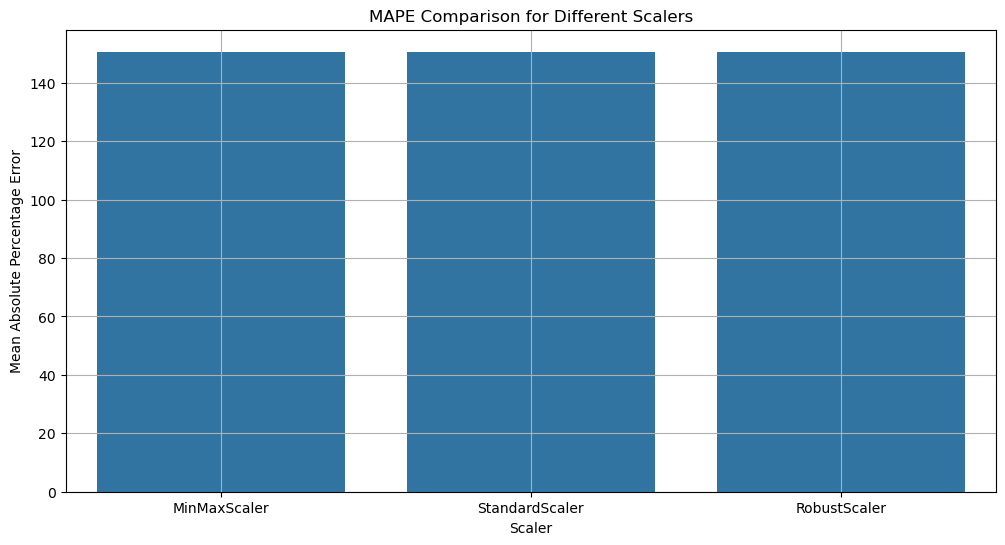

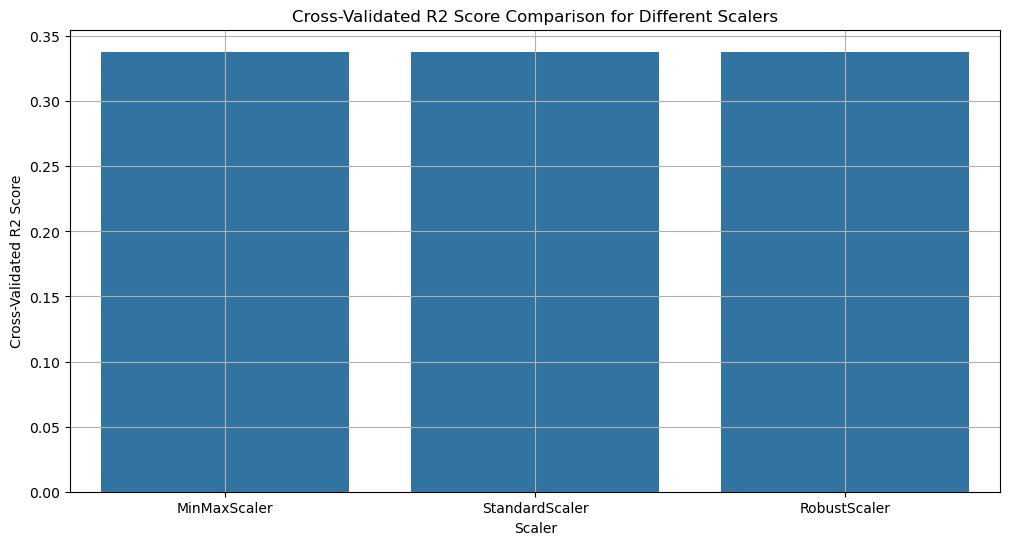

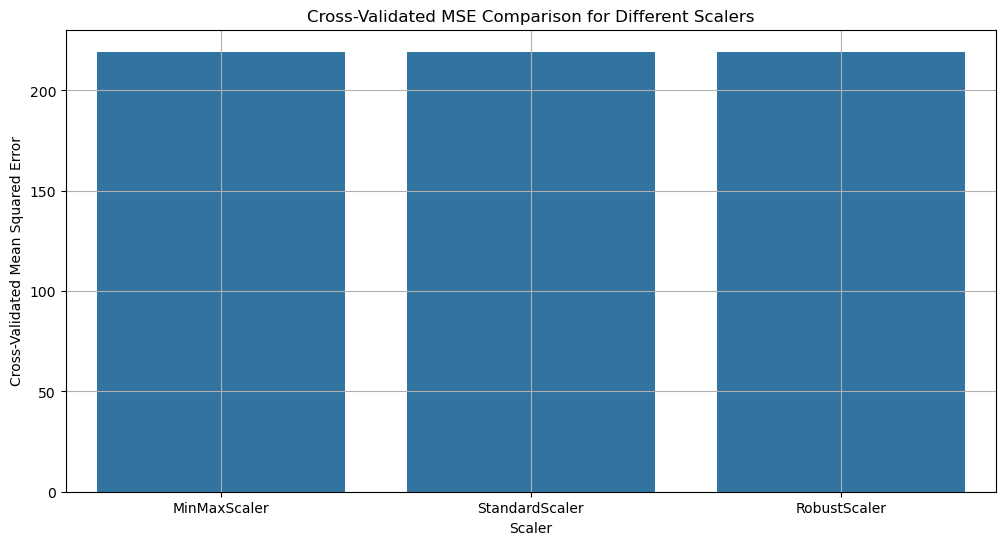

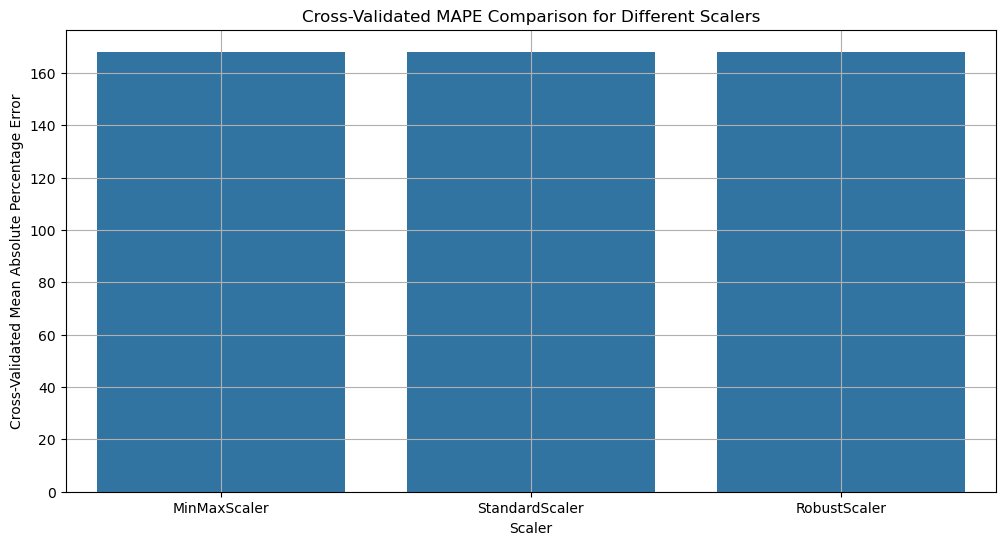

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
file_path = 'Updated_New_cleaned_dataset.csv'
data = pd.read_csv(file_path)

# Remove all columns related to time in seconds, minutes, and hours
columns_to_remove = ['time_diff_sec', 'time_diff_min', 'time_diff_hours']
data_cleaned = data.drop(columns=columns_to_remove)

# Define the target variable
target = 'time_diff_days'
X = data_cleaned.drop(columns=[target])
y = data_cleaned[target]

# Drop all object type columns and specified columns
columns_to_drop = [
    'user_id', 'order_id', 'submit_datetime', 'skuid', 'profile_created_time',
    'profile_created_time_sec', 'order_sumitted', 'COUNTRY',
    'COUNTRY_GROUPED_DE', 'COUNTRY_GROUPED_FR', 'COUNTRY_GROUPED_IN',
    'COUNTRY_GROUPED_Others', 'COUNTRY_GROUPED_US'
]

X = X.drop(columns=columns_to_drop)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scalers to compare
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': sp_randint(100, 1000),
    #'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth': sp_randint(3, 10),
    'model__min_samples_split': sp_randint(2, 11),
    'model__min_samples_leaf': sp_randint(1, 11),
    'model__bootstrap': [True, False]
}

# Initialize results dictionary
results = []

# Loop through each scaler
for scaler_name, scaler in scalers.items():
    print(f"Evaluating with {scaler_name}")
    
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', RandomForestRegressor(random_state=42))
    ])
    
    # Initialize RandomizedSearchCV with verbose output
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, 
        n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Print the best parameters
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    print(f"Best parameters found with {scaler_name}: ", best_params)
    print(f"Best cross-validation score with {scaler_name}: ", best_score)
    
    # Evaluate the best model on the test set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Compute residuals
    residuals = y_test - y_pred
    
    # Perform cross-validation on the training set
    cv_mse = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
    cv_mape = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_percentage_error))
    cv_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    
    results.append({
        'Scaler': scaler_name,
        'MSE': mse,
        'MAPE': mape,
        'R2': r2,
        'CV_MSE': np.mean(cv_mse),
        'CV_MAPE': np.mean(cv_mape),
        'CV_R2': np.mean(cv_r2),
        'Residuals': residuals,
        'FeatureImportances': best_model.named_steps['model'].feature_importances_
    })

    # Create DataFrame with actual and predicted values
    results_df_rf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    # Plot histogram of actual vs predicted values
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df_rf.melt(), bins = 100, x='value', hue='variable', kde=True)
    plt.title(f'{scaler_name}: Actual vs Predicted Values')
    plt.xlabel('Time Difference (Days)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

# Create DataFrame for results
results_df = pd.DataFrame(results)



# Plot the comparison results
plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='R2', data=results_df)
plt.title('R2 Score Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('R2 Score')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='MSE', data=results_df)
plt.title('MSE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='MAPE', data=results_df)
plt.title('MAPE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Mean Absolute Percentage Error')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='CV_R2', data=results_df)
plt.title('Cross-Validated R2 Score Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Cross-Validated R2 Score')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='CV_MSE', data=results_df)
plt.title('Cross-Validated MSE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Cross-Validated Mean Squared Error')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Scaler', y='CV_MAPE', data=results_df)
plt.title('Cross-Validated MAPE Comparison for Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Cross-Validated Mean Absolute Percentage Error')
plt.grid()
plt.show()


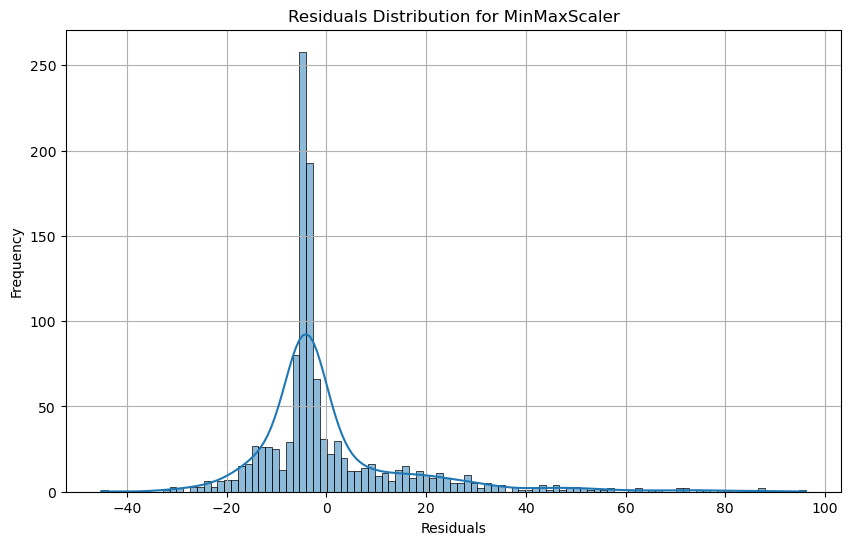

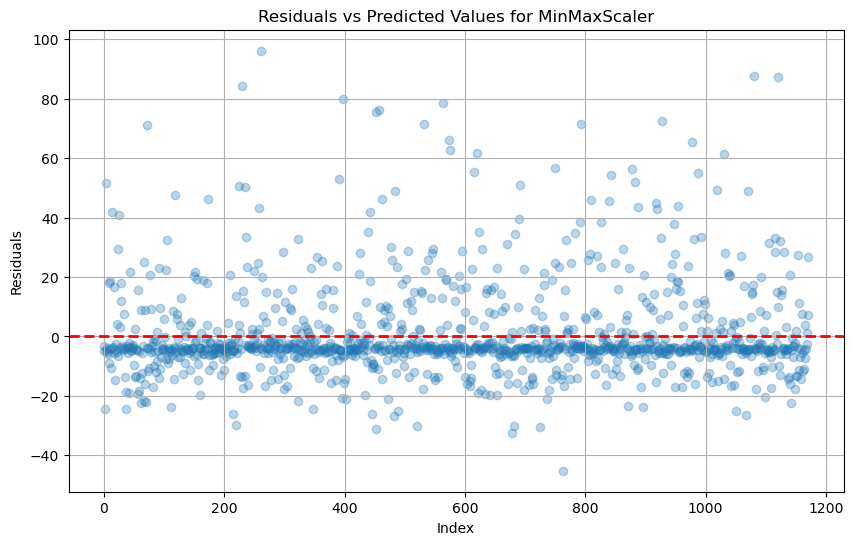

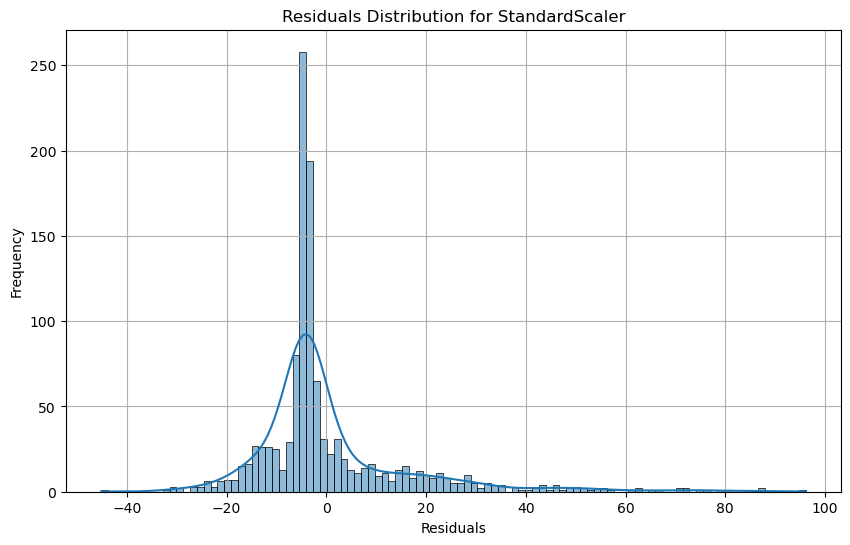

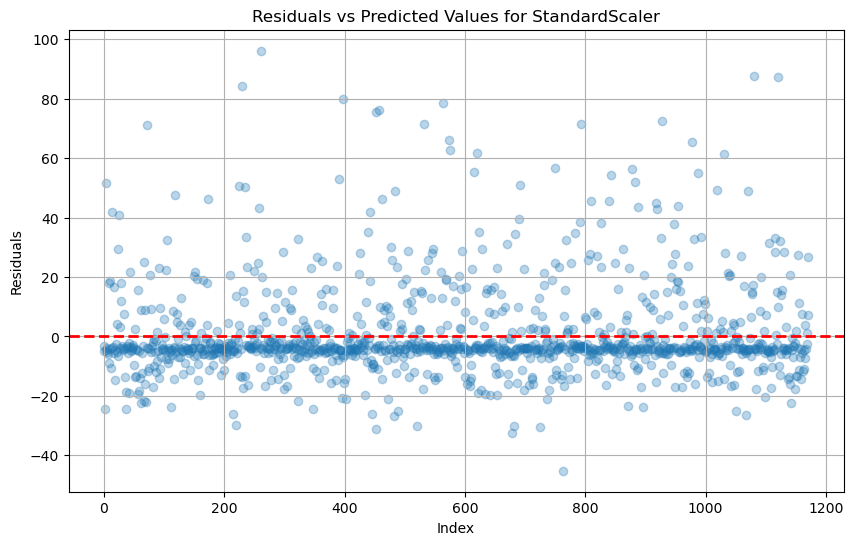

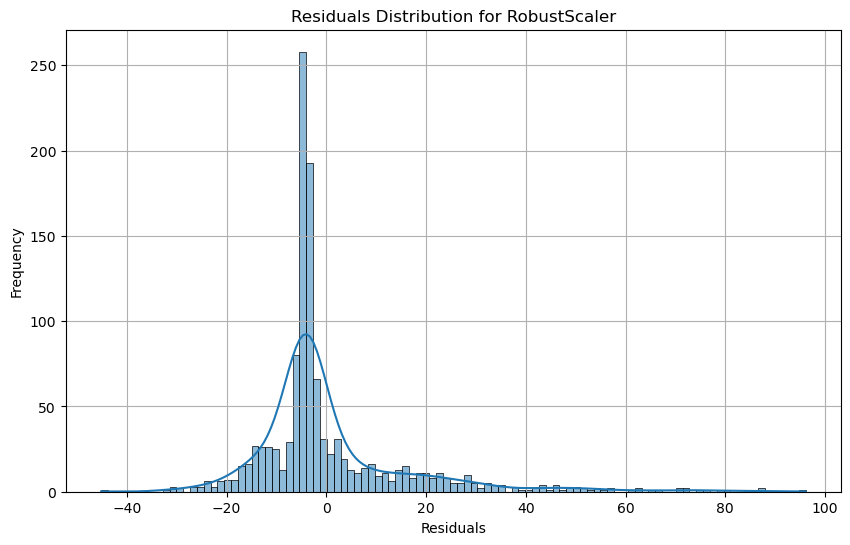

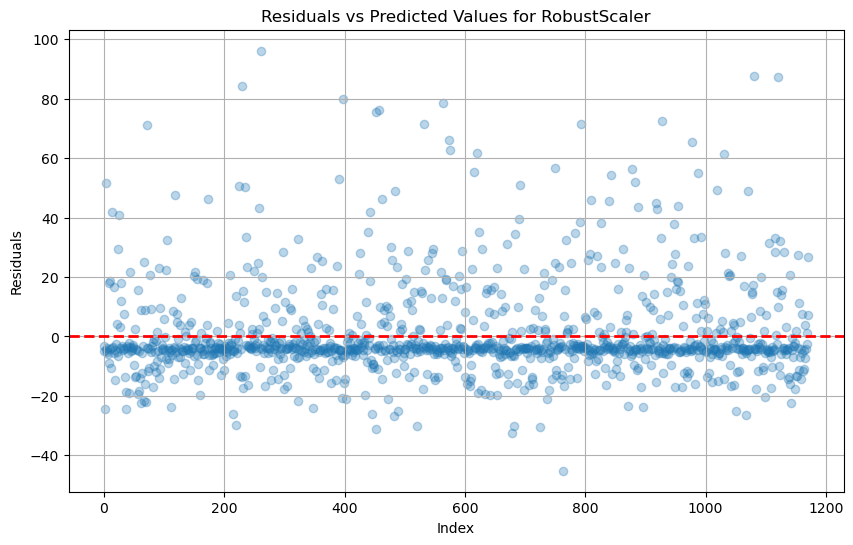

In [6]:
# Analyze residuals for each model
for result in results:
    scaler_name = result['Scaler']
    residuals = result['Residuals']
    
    # Plot histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Residuals Distribution for {scaler_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    
    # Plot residuals vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(residuals)), residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.title(f'Residuals vs Predicted Values for {scaler_name}')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()


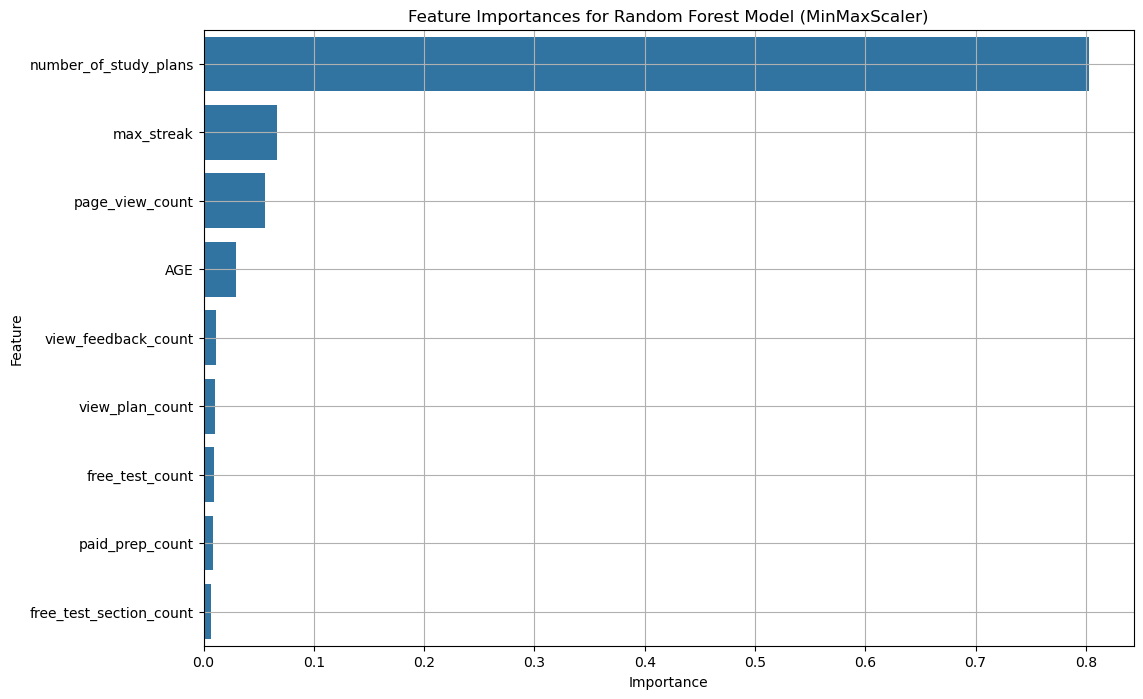

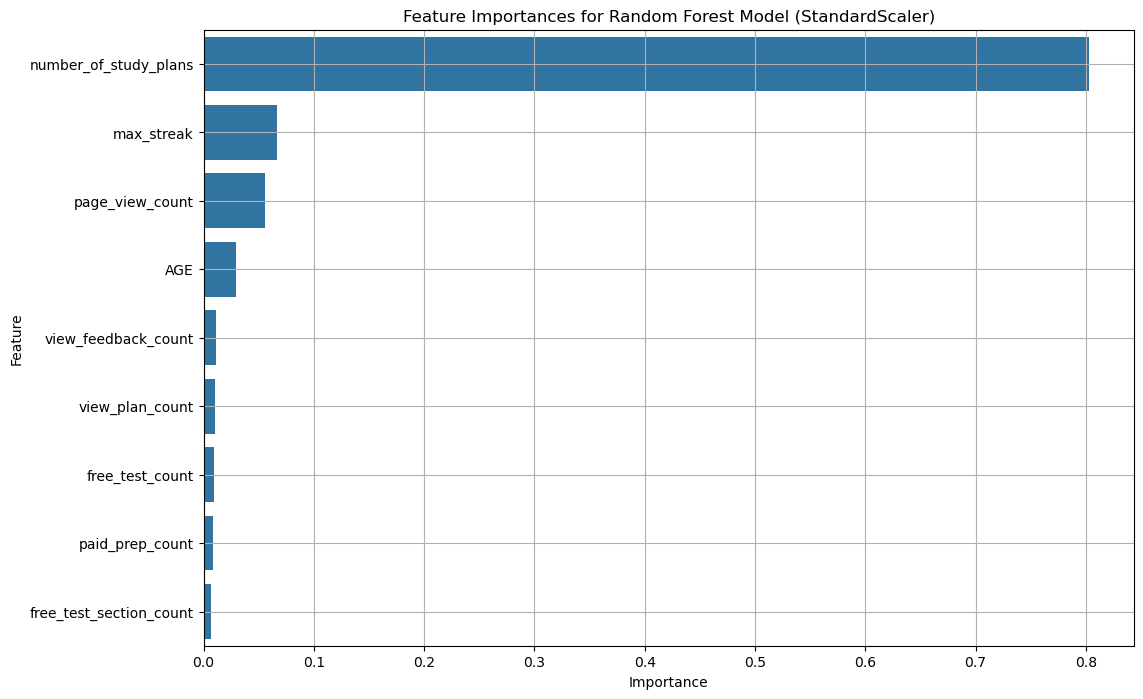

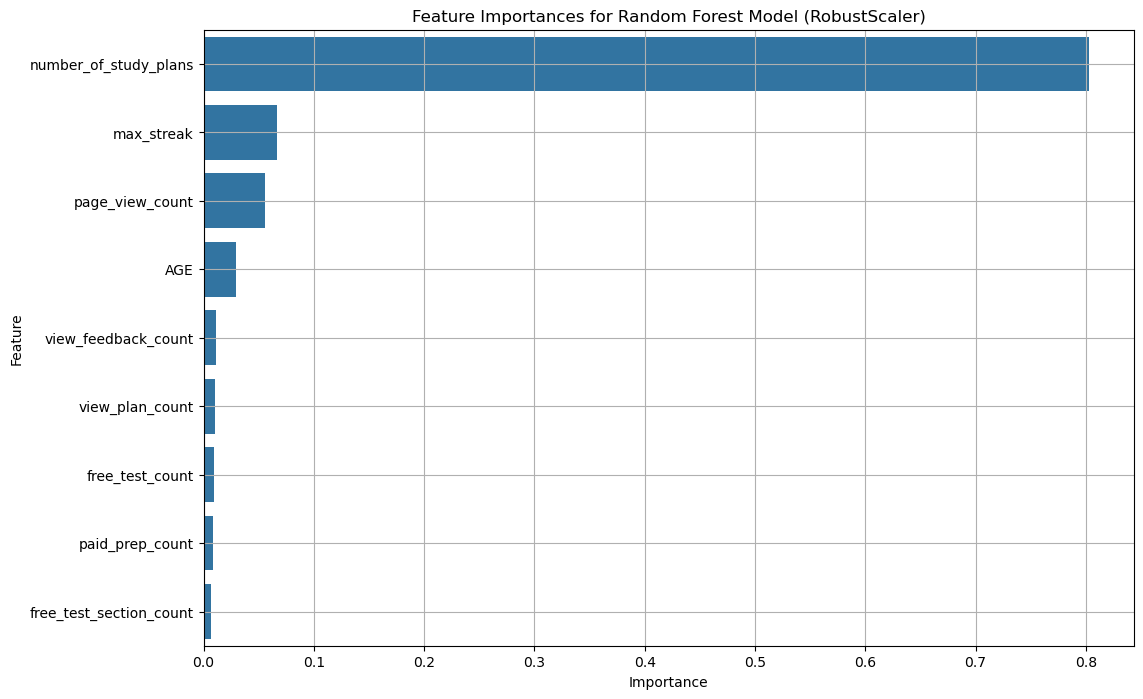

In [7]:
# Feature importance analysis
features = X.columns

for result in results:
    scaler_name = result['Scaler']
    feature_importances = result['FeatureImportances']
    
    # Create a DataFrame for feature importances
    feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    
    # Sort the DataFrame by importance
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title(f'Feature Importances for Random Forest Model ({scaler_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid()
    plt.show()

In [8]:
# Create DataFrame for results
results_df = pd.DataFrame(results)
results_df

,Scaler,MSE,MAPE,R2,CV_MSE,CV_MAPE,CV_R2,Residuals,FeatureImportances
0,MinMaxScaler,257.989591,150.659315,0.252970,219.313246,168.024367,0.338042,5217 -3.306905 3671 -5.017266 1505 -24...,"[0.029433633361741797, 0.006311044537498602, 0..."
1,StandardScaler,257.955002,150.656739,0.253071,219.315839,168.119088,0.338050,5217 -3.306905 3671 -5.017266 1505 -24...,"[0.029433633361741797, 0.006311044537498602, 0..."
2,RobustScaler,257.962723,150.657950,0.253048,219.313355,168.135391,0.338056,5217 -3.306905 3671 -5.017266 1505 -24...,"[0.029433633361741797, 0.006311044537498602, 0..."
